# Plotting time-series in R using pluto

A getting started guide

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
source("config.R")
source("goofy/plot.common.R")

indices<-Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from

Let's pick a long time-series. This will allow us to play with different aspects of plotting...

In [2]:
cutOff <- Sys.Date() - 10
trIndices <- indices$NseTimeSeries() %>%
    group_by(NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    filter(ST <= '2005-01-01' && ET >= cutOff && NAME %like% '% TR') %>%
    arrange(ST)

trIndices %>% print(n=Inf)

Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# Source:     lazy query [?? x 3]
# Database:   Microsoft SQL Server 13.00.4259[ro1@NORWAY/StockViz]
# Ordered by: ST
   NAME                        ST         ET        
   <chr>                       <date>     <date>    
 1 NIFTY50 EQUAL WEIGHT TR     1995-11-03 2019-08-01
 2 NIFTY 500 TR                1998-11-26 2019-08-01
 3 NIFTY FMCG TR               1998-11-26 2019-08-01
 4 NIFTY MNC TR                1998-11-26 2019-08-01
 5 NIFTY SERVICES SECTOR TR    1999-06-01 2019-08-01
 6 NIFTY 50 TR                 1999-06-30 2019-08-01
 7 NIFTY IT TR                 1999-06-30 2019-08-01
 8 NIFTY BANK TR               2000-01-01 2019-08-01
 9 NIFTY PSE TR                2000-01-03 2019-08-01
10 NIFTY ENERGY TR             2001-01-01 2019-08-01
11 NIFTY PHARMA TR             2001-01-01 2019-08-01
12 NIFTY NEXT 50 TR            2002-11-08 2019-08-01
13 NIFTY MIDCAP 100 TR         2003-01-01 2019-08-01
14 NIFTY 100 TR                2003-01-01 2019-08-01
15 NIFTY100 EQUAL WEIGHT TR    200

NIFTY 500 TR makes a good candidate. It is a broad based index the represents the top-500 stocks by free-float market cap listed on the NSE...

In [3]:
indexName <- "NIFTY 500 TR"
trDf <- data.frame(indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, HIGH, LOW, OPEN, CLOSE))
trXts<-xts(trDf[,-1], trDf[,1])

print(head(trXts))
print(tail(trXts))

           HIGH LOW OPEN  CLOSE
1998-11-26   NA  NA   NA 611.43
1998-11-27   NA  NA   NA 603.22
1998-11-28   NA  NA   NA 602.15
1998-11-30   NA  NA   NA 607.47
1998-12-01   NA  NA   NA 606.23
1998-12-02   NA  NA   NA 609.96
           HIGH LOW OPEN    CLOSE
2019-07-25   NA  NA   NA 13690.06
2019-07-26   NA  NA   NA 13740.26
2019-07-29   NA  NA   NA 13616.28
2019-07-30   NA  NA   NA 13459.90
2019-07-31   NA  NA   NA 13522.10
2019-08-01   NA  NA   NA 13362.08


Note: the series only has closing prices. 

In [4]:
#setup the data for ggplot
firstDate <- first(index(trXts))
lastDate <- last(index(trXts))
xAxisTicks <- seq(from=firstDate, to=lastDate, length.out=10)

toPlotDf <- data.frame(trXts[, 'CLOSE'])
names(toPlotDf) <- c('C')
toPlotDf$T <- index(trXts)

options(repr.plot.width=16, repr.plot.height=8)

### plot the series as-is

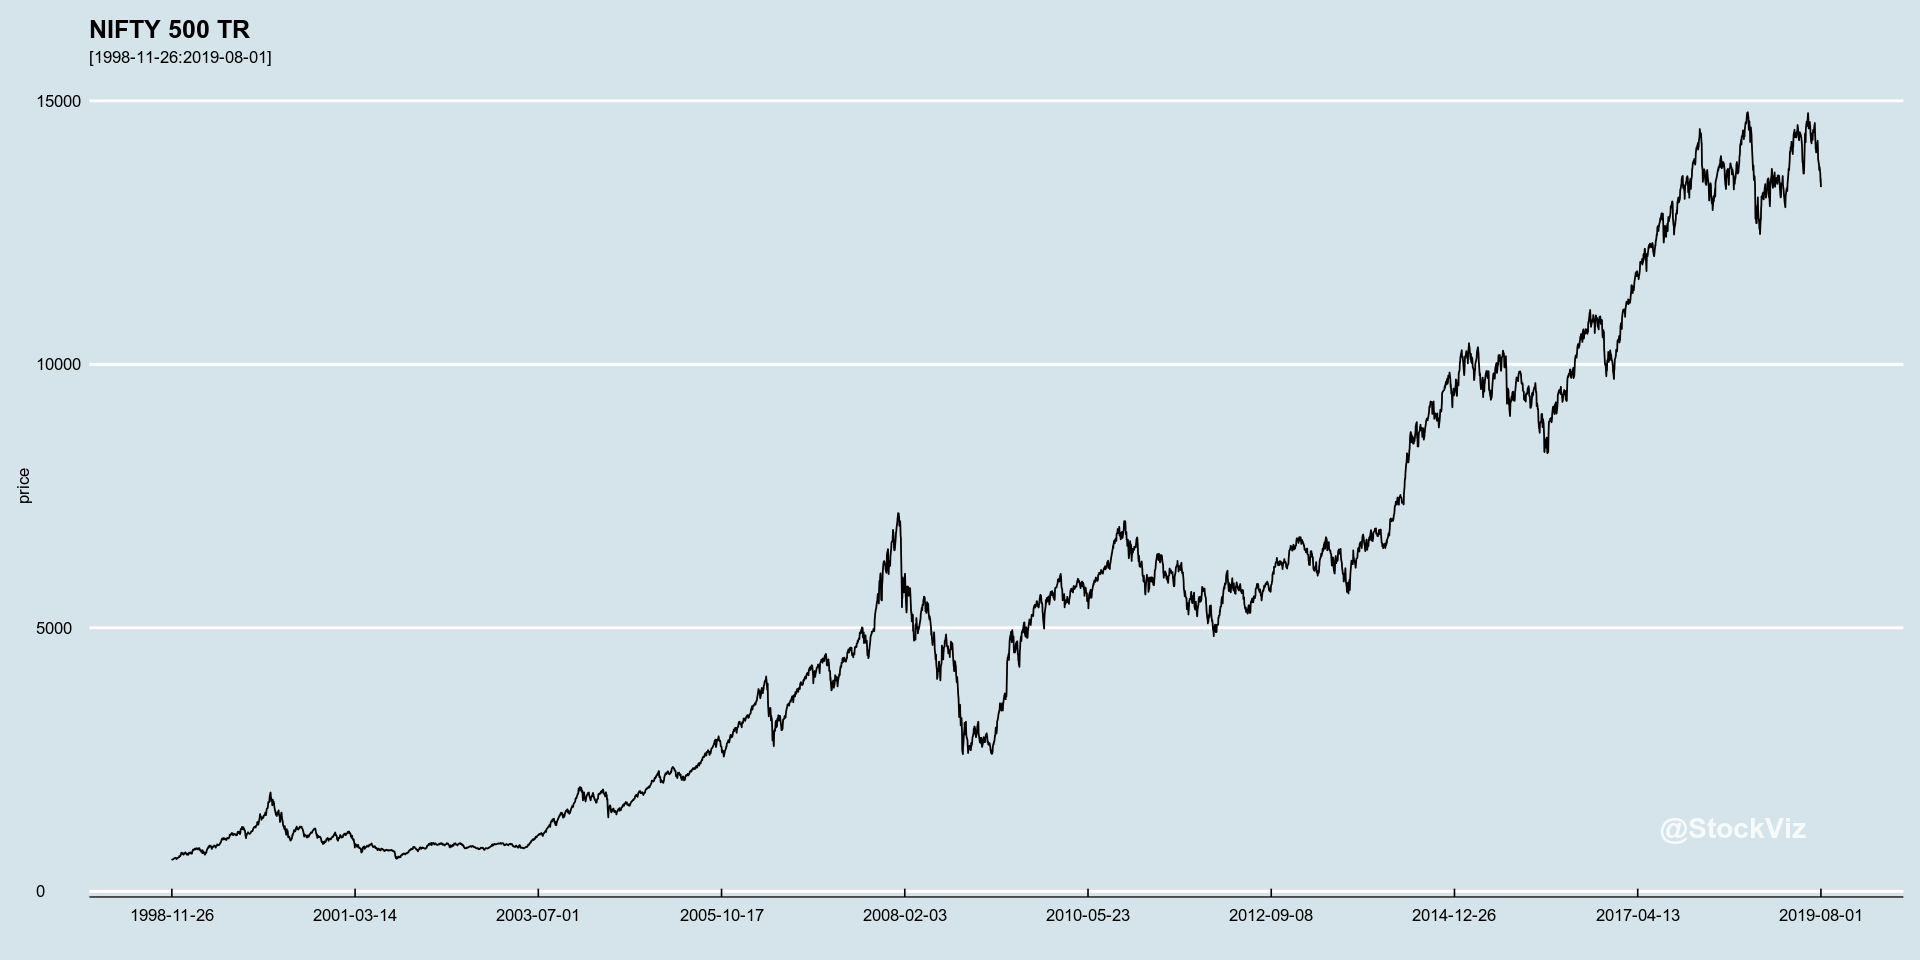

In [5]:
ggplot(toPlotDf, aes(x=T, y=C)) +
    theme_economist() +
    geom_line() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='price', color='', title=sprintf("%s", indexName), subtitle=sprintf("[%s:%s]", firstDate, lastDate)) +
    annotate("text", x=lastDate, y=min(toPlotDf$C, na.rm=T), label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

### plot log-scale

When using a logarithmic scale, the vertical distance between the prices on the scale will be equal when the percent change between the values is the same. Using the above example, the distance between 10 and 15 would be equal to the distance between 20 and 30 because they both represent a price increase of 50%.
[investopedia](https://www.investopedia.com/ask/answers/05/logvslinear.asp)

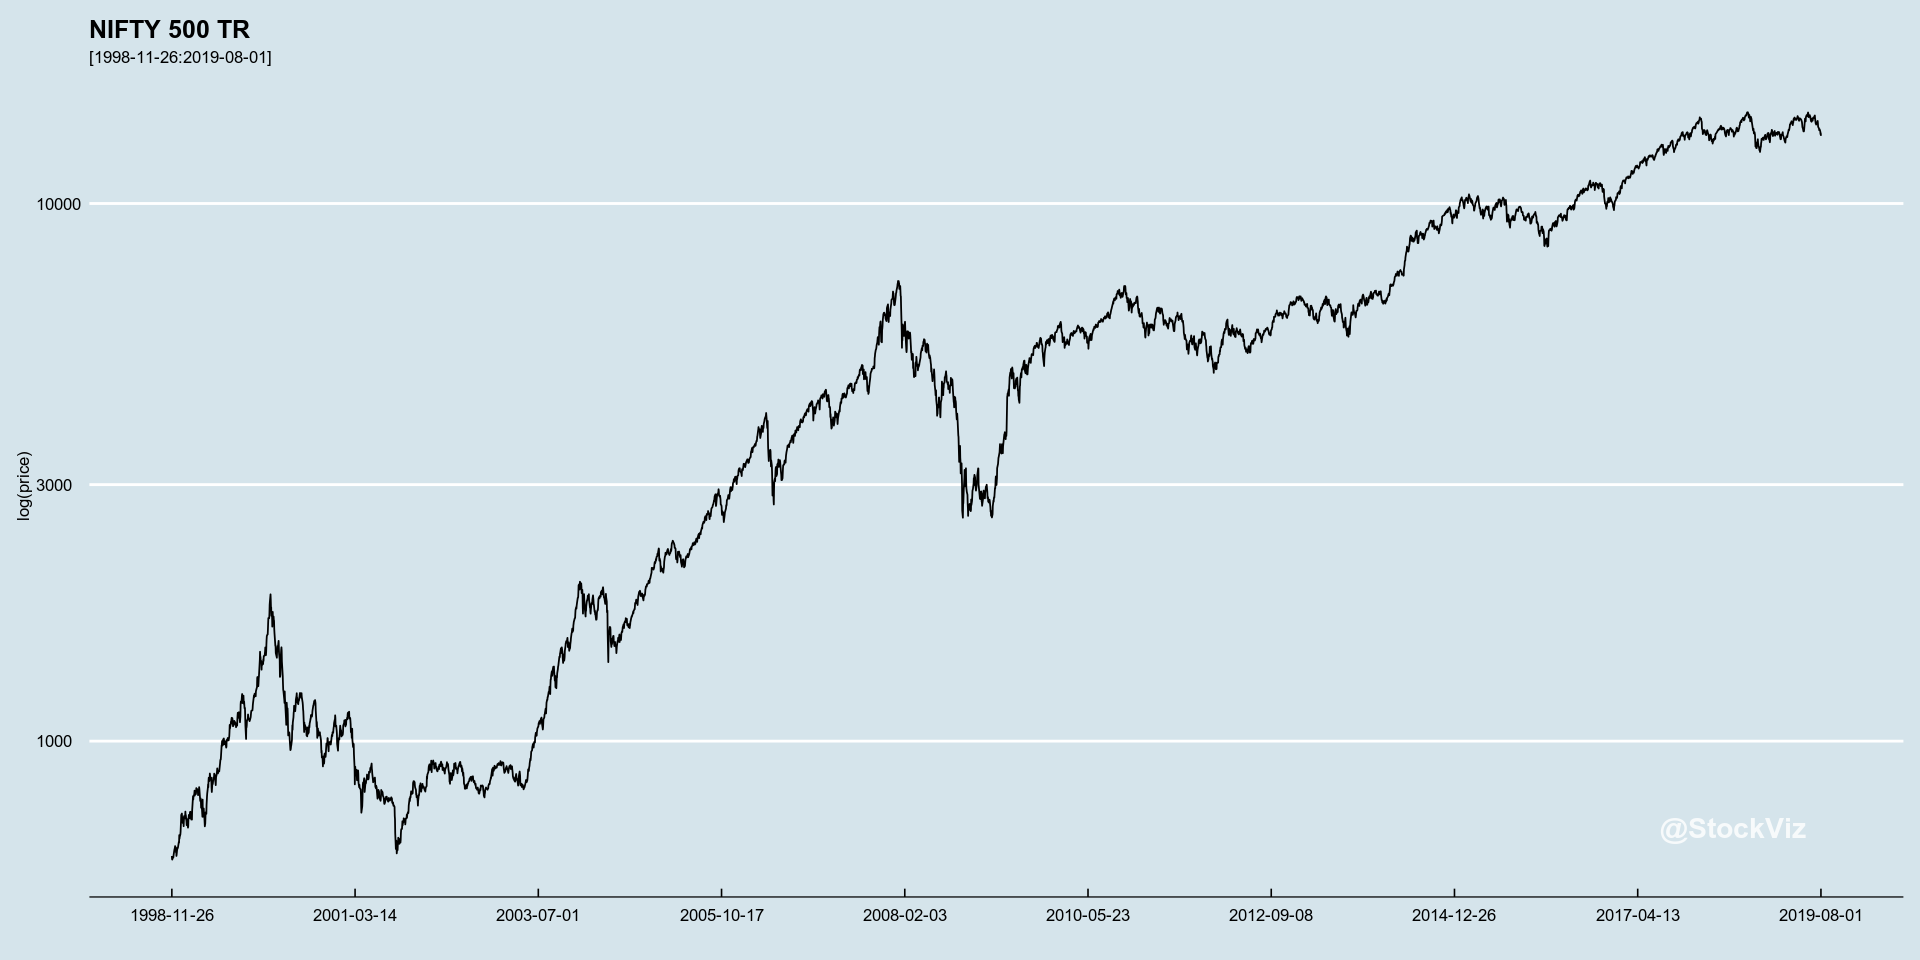

In [6]:
ggplot(toPlotDf, aes(x=T, y=C)) +
    theme_economist() +
    geom_line() +
    scale_y_log10() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='log(price)', color='', title=sprintf("%s", indexName), subtitle=sprintf("[%s:%s]", firstDate, lastDate)) +
    annotate("text", x=lastDate, y=min(toPlotDf$C, na.rm=T), label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

### plot monthly candlestick chart

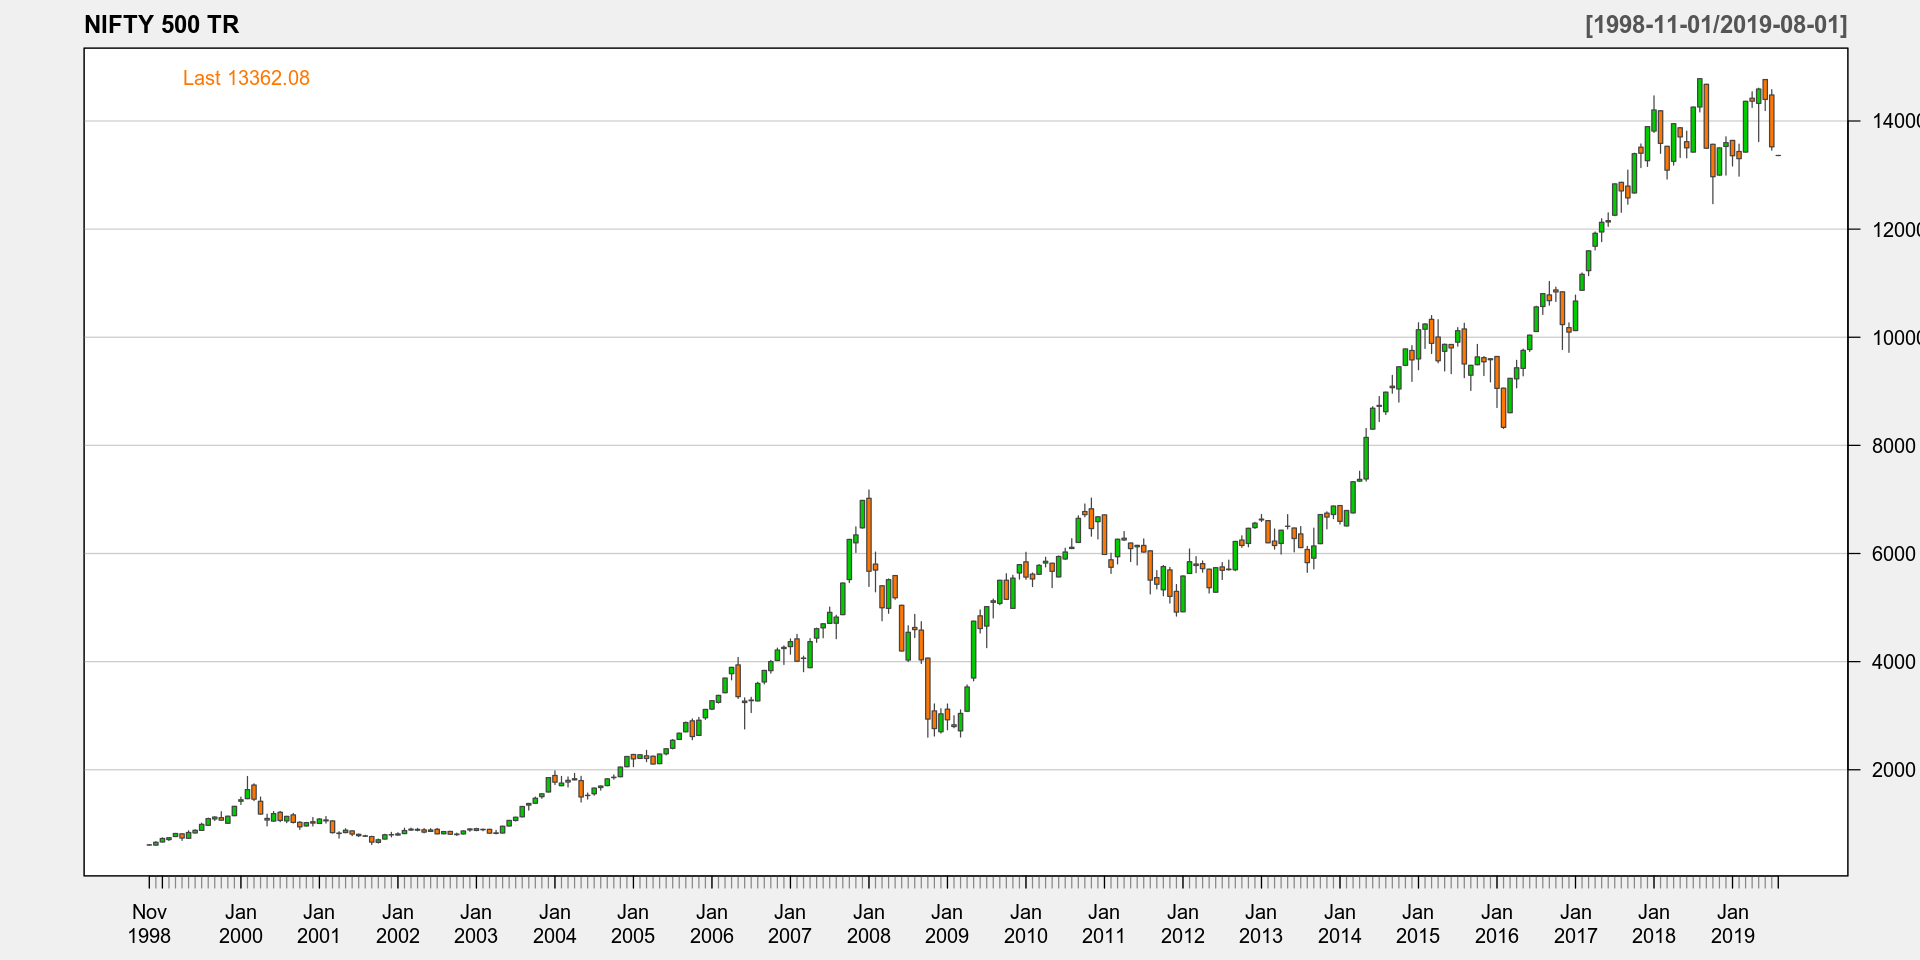

In [7]:
monthlyTr <- to.monthly(trXts$CLOSE)
names(monthlyTr) <- c('Open', 'High', 'Low', 'Close')

chartSeries(monthlyTr, theme = 'white', name = indexName)

#### add some chart studies...

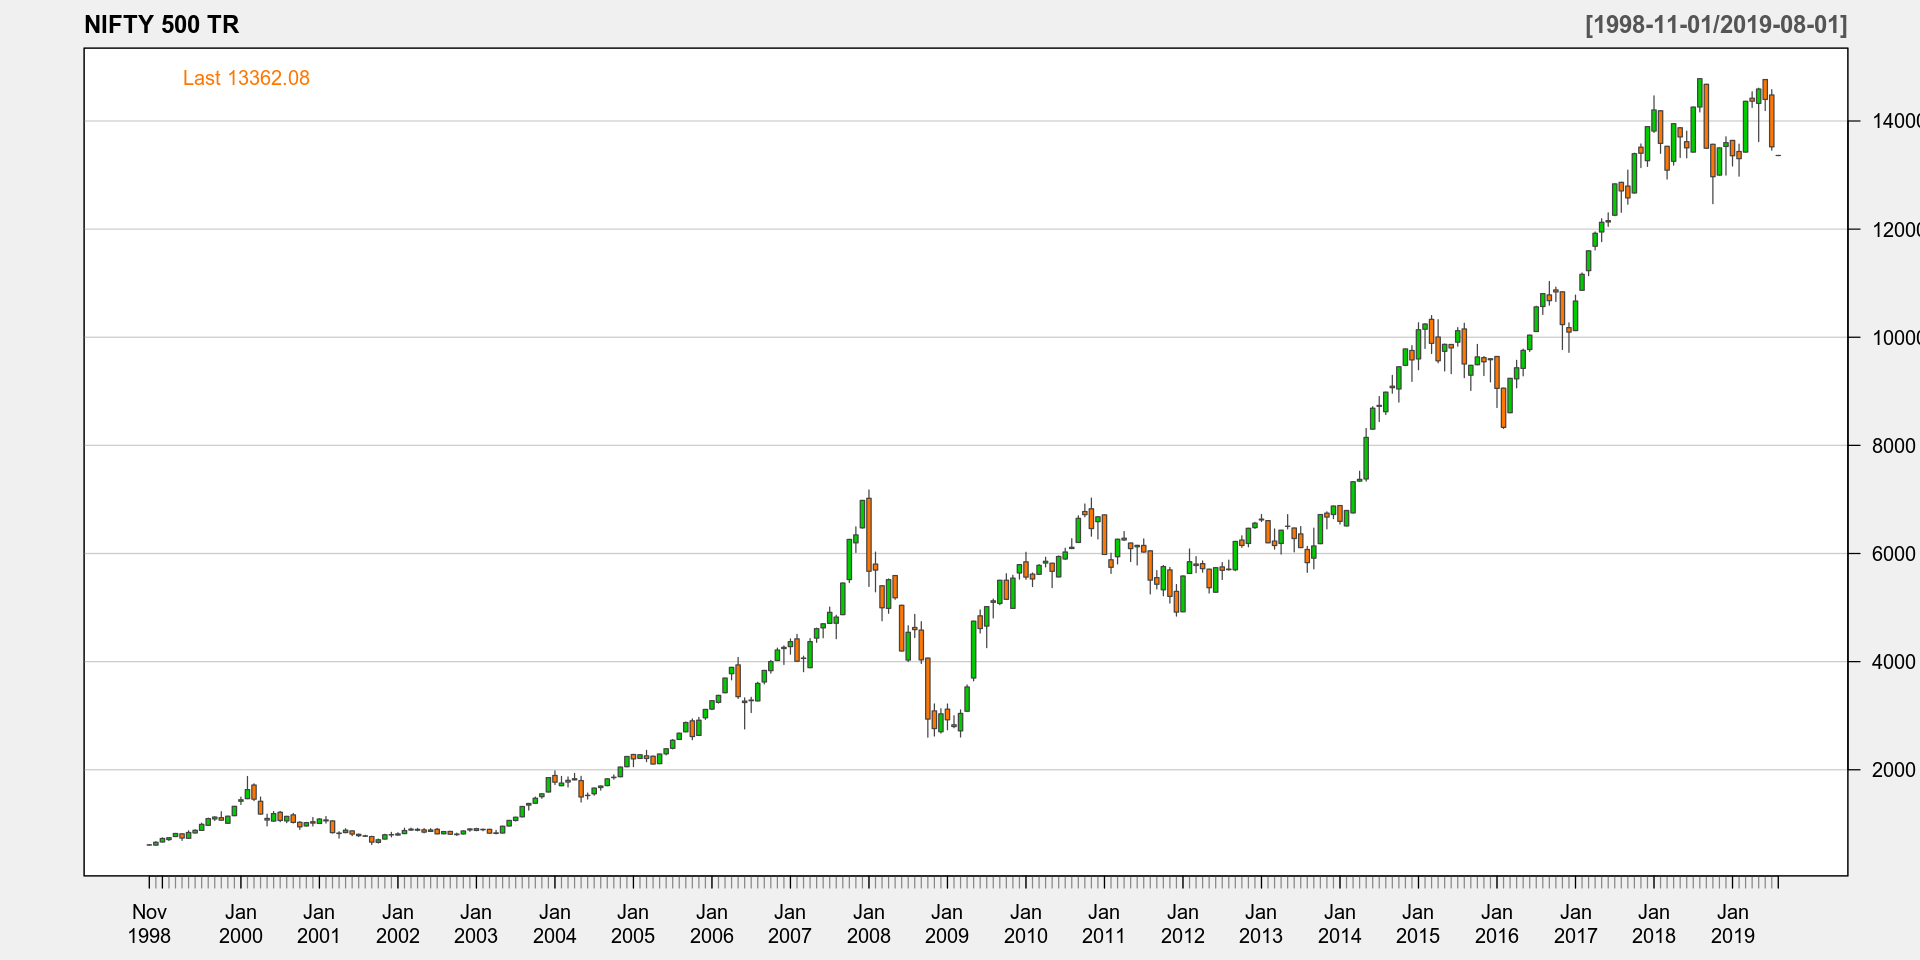

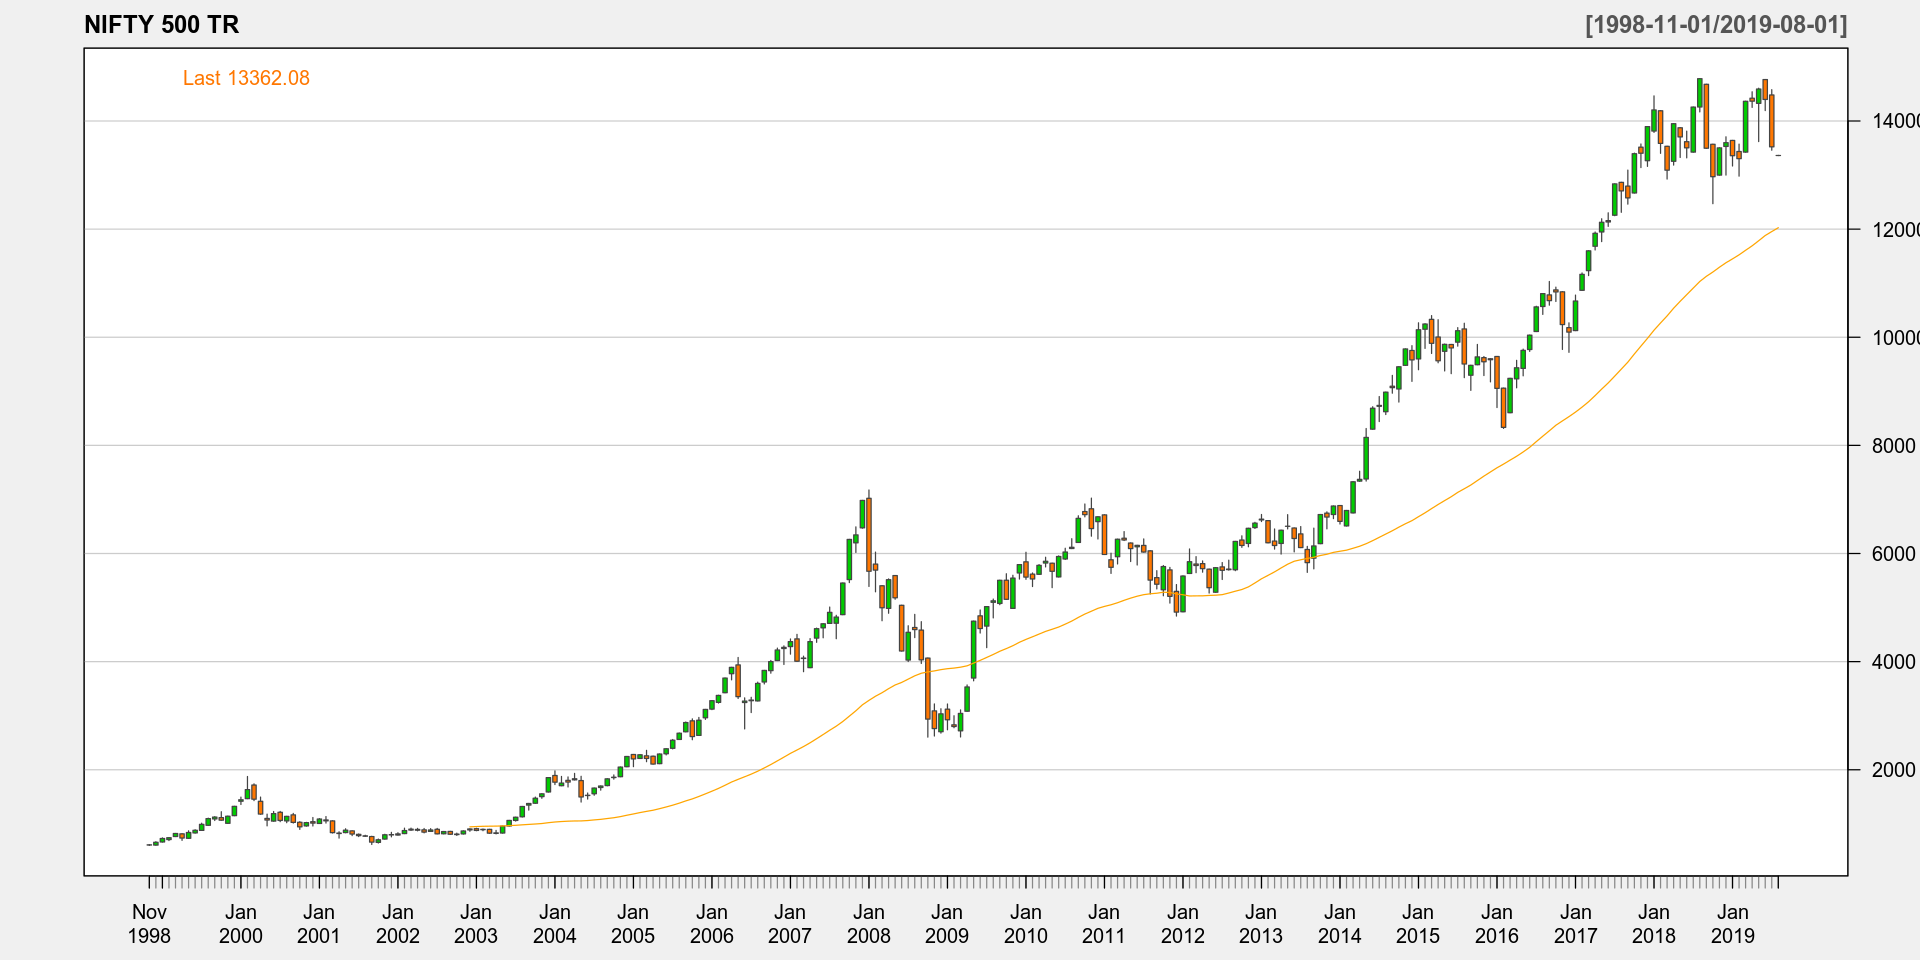

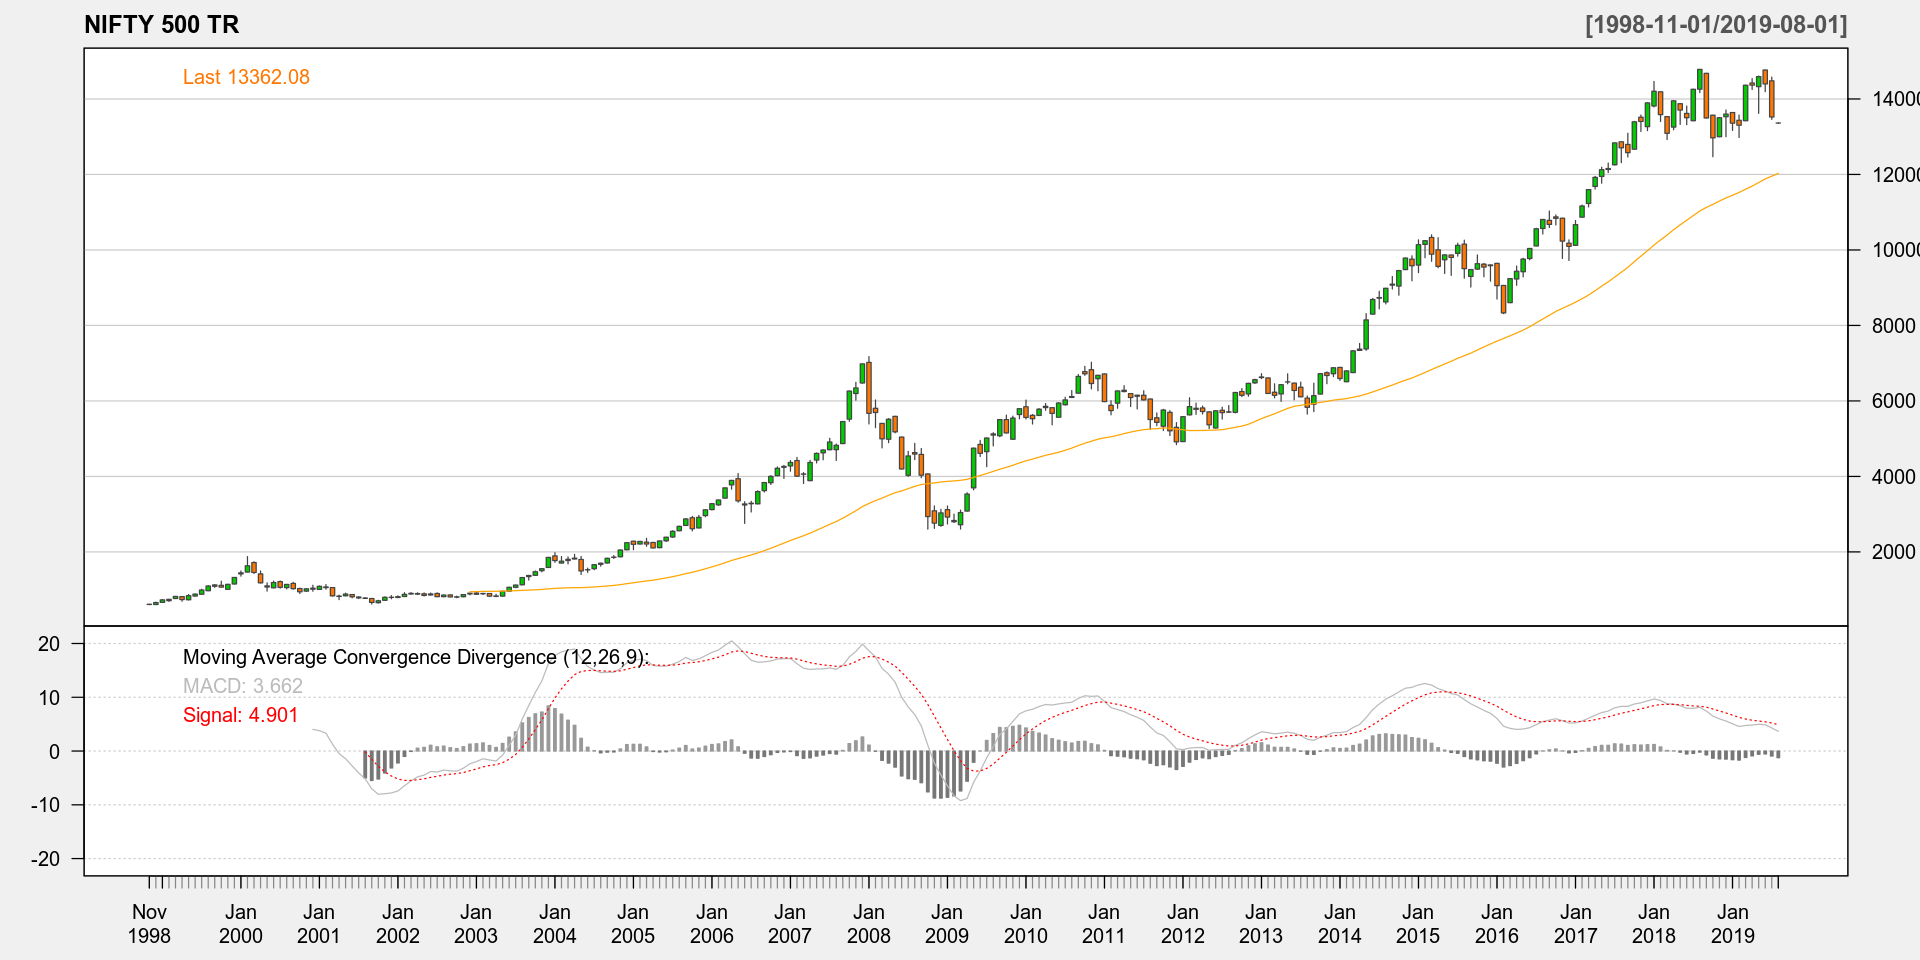

In [8]:
chartSeries(tail(monthlyTr, 1000), theme = 'white', name = indexName)
addSMA(50, col='orange')
addMACD()

#### ... and if you want only one chart:

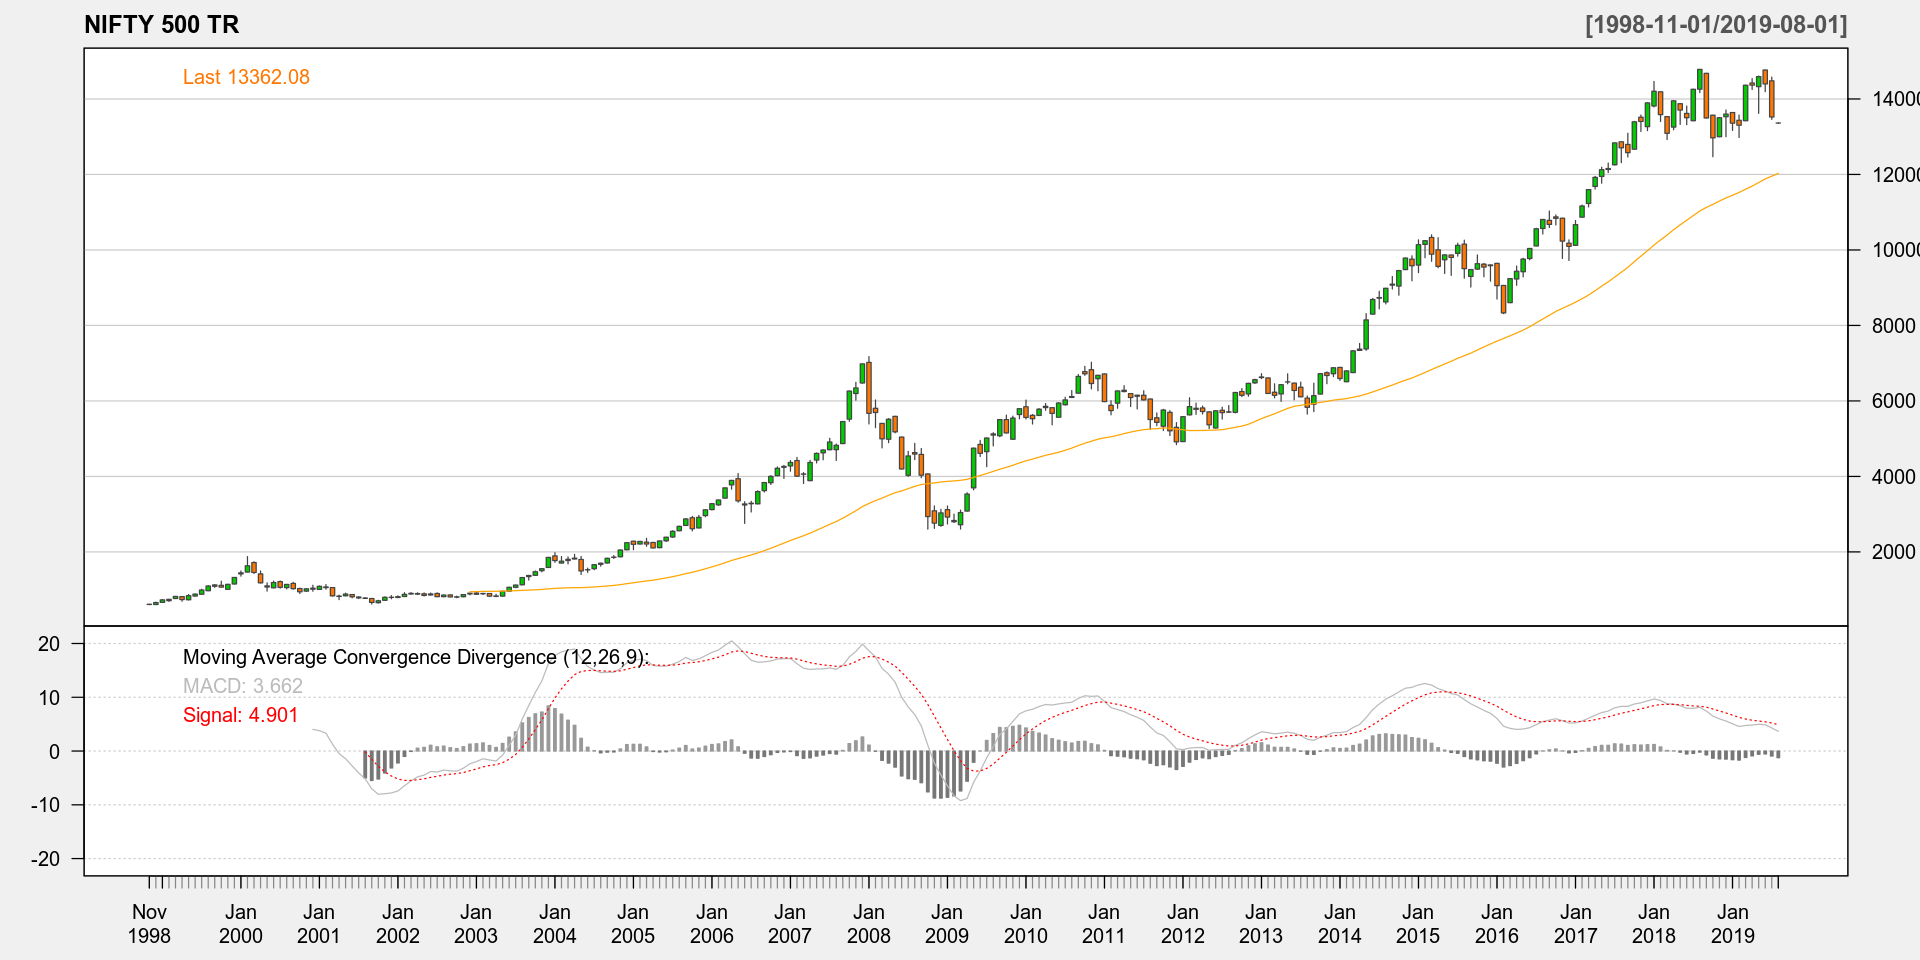

In [9]:
chartSeries(tail(monthlyTr, 1000), theme = 'white', name = indexName,
           TA=list("addSMA(50, col='orange')",
                  "addMACD()"))

### cumulative returns and drawdowns

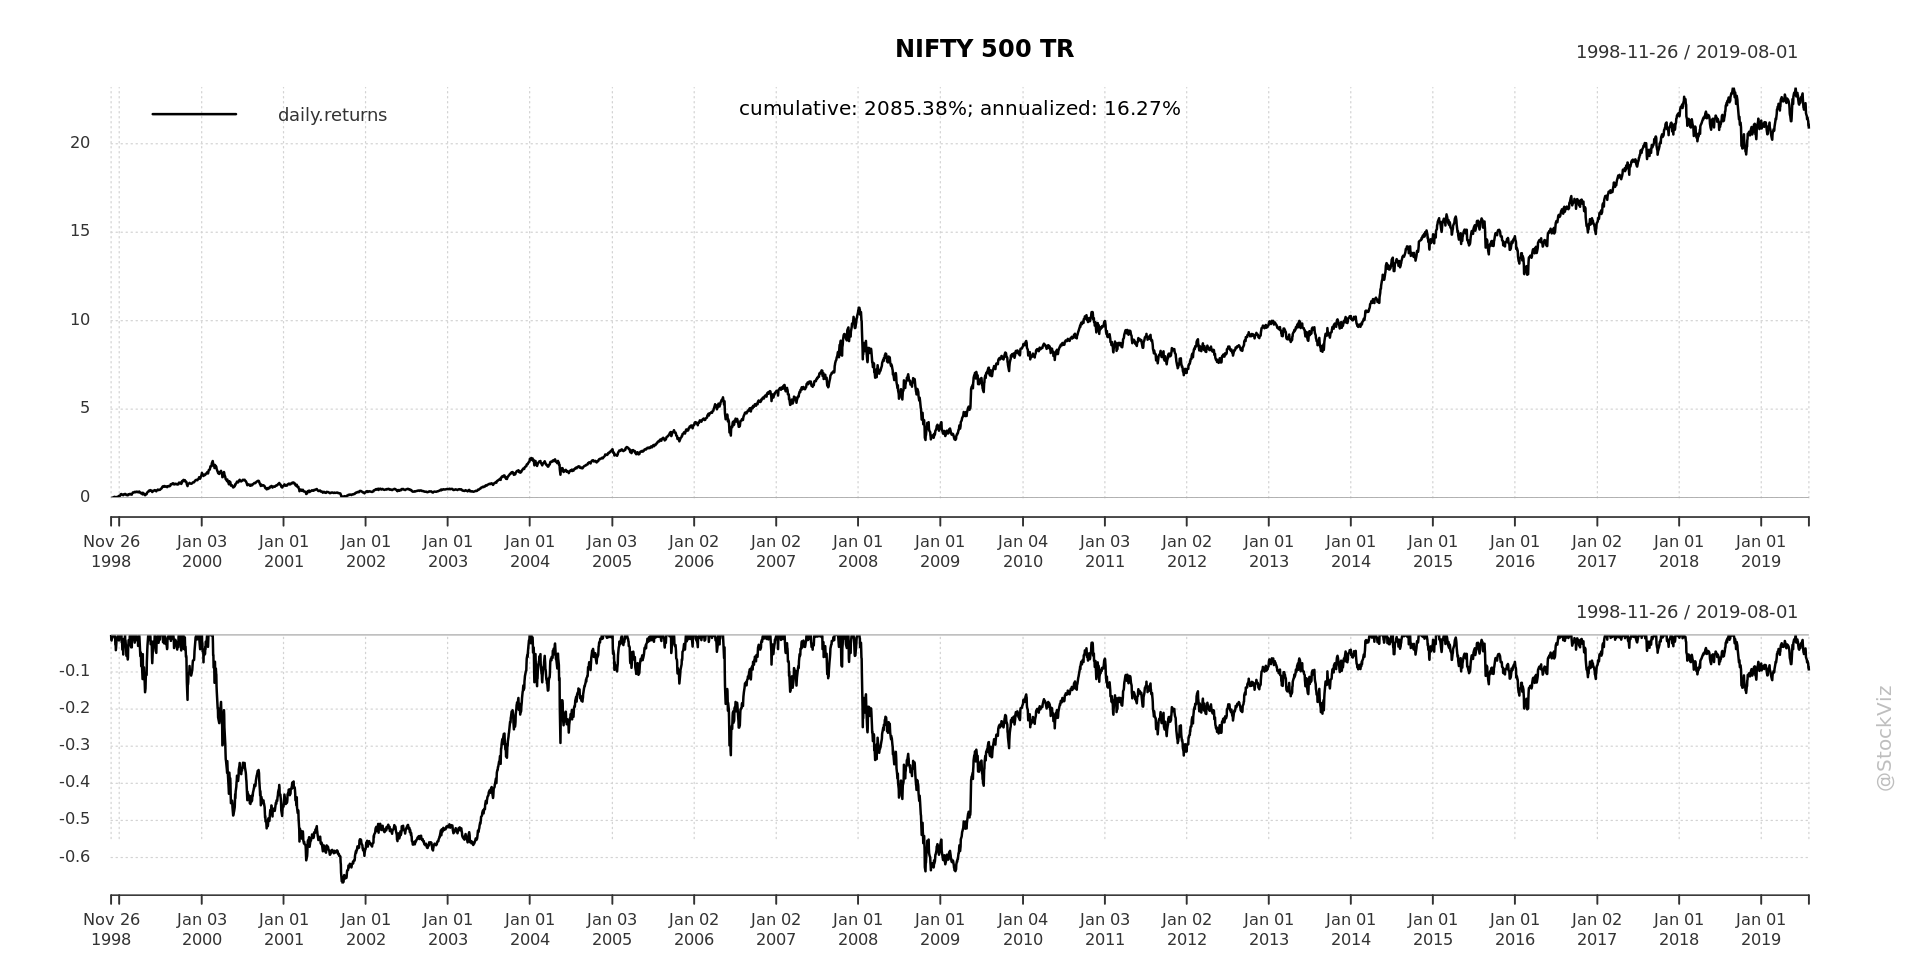

In [10]:
dailies <- dailyReturn(trXts[, 'CLOSE'])
Common.PlotCumReturns(dailies, indexName, NA)

#### subsetting

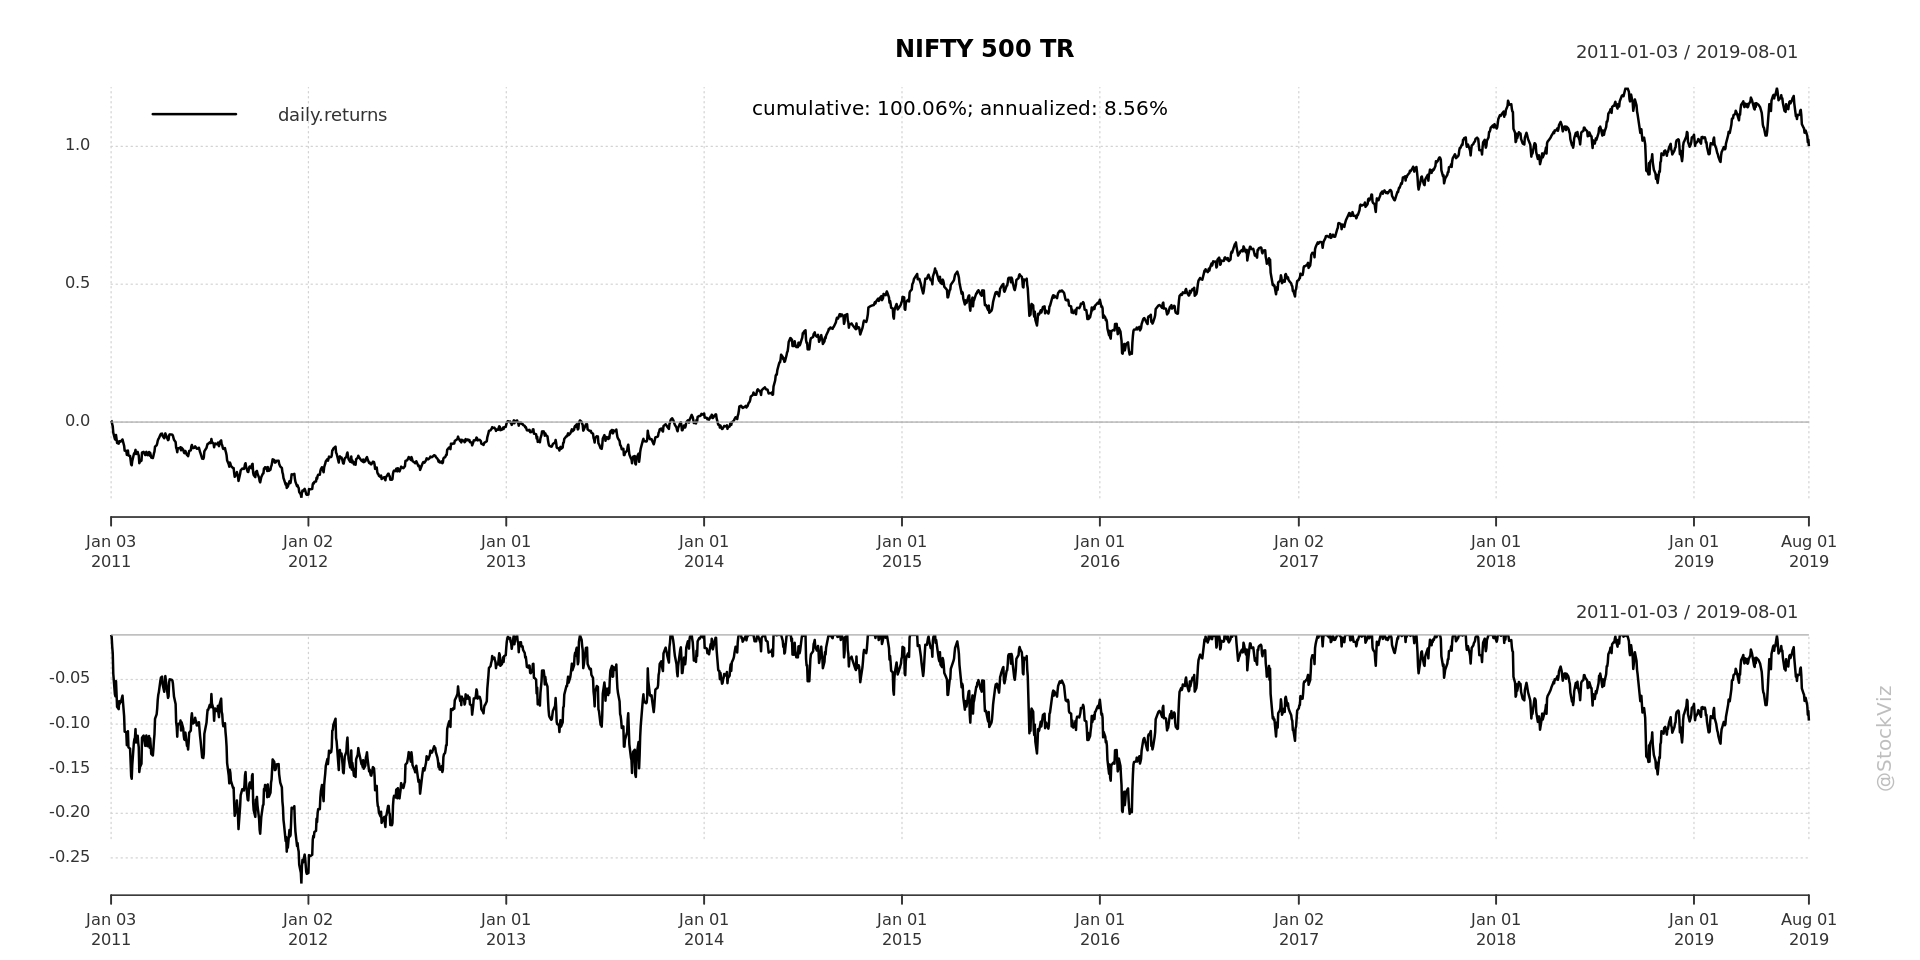

In [11]:
Common.PlotCumReturns(dailies["2011/"], indexName, NA)

### drawdown table

In [12]:
print(table.Drawdowns(dailies, 10))

         From     Trough         To   Depth Length To Trough Recovery
1  2000-02-22 2001-09-21 2004-01-01 -0.6702    969       398      571
2  2008-01-07 2008-10-27 2014-03-27 -0.6371   1546       200     1346
3  2006-05-11 2006-06-14 2006-11-10 -0.3242    130        25      105
4  2004-01-09 2004-05-17 2004-11-17 -0.2911    217        87      130
5  2015-03-04 2016-02-25 2016-07-22 -0.2006    343       244       99
6  1999-10-15 1999-11-01 1999-12-10 -0.1750     40        12       28
7  2018-09-03 2018-10-26       <NA> -0.1564    226        36       NA
8  1999-04-01 1999-04-26 1999-05-11 -0.1545     27        17       10
9  2007-02-08 2007-03-05 2007-05-17 -0.1532     66        17       49
10 2005-10-05 2005-10-28 2005-11-28 -0.1310     36        17       19


#### subsetting

In [13]:
print(table.Drawdowns(dailies["2011/"], 10))

         From     Trough         To   Depth Length To Trough Recovery
1  2011-01-04 2011-12-20 2013-01-15 -0.2788    508       238      270
2  2015-03-04 2016-02-25 2016-07-22 -0.2006    343       244       99
3  2013-01-16 2013-08-28 2013-11-01 -0.1592    199       155       44
4  2018-09-03 2018-10-26       <NA> -0.1564    226        36       NA
5  2016-09-09 2016-12-26 2017-02-06 -0.1187    102        73       29
6  2018-01-24 2018-03-23 2018-08-20 -0.1063    142        40      102
7  2014-12-05 2014-12-17 2015-01-16 -0.0671     30         9       21
8  2014-01-02 2014-02-03 2014-03-06 -0.0548     45        23       22
9  2014-09-23 2014-10-16 2014-10-31 -0.0531     24        14       10
10 2014-07-08 2014-07-14 2014-08-19 -0.0519     29         5       24


This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)